# Summary

# Imports

In [1]:
%run _imports.ipynb

Setting the PYTHON_VERSION environment variable.
Setting the SPARK_MASTER environment variable.
Setting the SPARK_ARGS environment variable.
Setting the DB_TYPE environment variable.
Setting the DB_PORT environment variable.


2017-11-29 11:25:34.786083


In [2]:
NOTEBOOK_NAME = 'train_neural_network'
NOTEBOOK_PATH = Path(NOTEBOOK_NAME).absolute()
NOTEBOOK_PATH.mkdir(exist_ok=True)

# Parameters

## Input

In [3]:
INPUT_DATA_PATH = Path('construct_adjacency_matrix/adjacency_matrix_test/').absolute()

In [4]:
INPUT_PARQUET_FILES = list(INPUT_DATA_PATH.glob('*/*.parquet'))

In [5]:
INPUT_PARQUET_FILES

[PosixPath('/home/kimlab2/database_data/datapkg/uniparc_domain/notebooks/construct_adjacency_matrix/adjacency_matrix_test/database_id=G3DSA%3A3.20.20.70/result.parquet')]

## Output

# Data

In [6]:
result_df = pq.read_table(INPUT_PARQUET_FILES[0].as_posix()).to_pandas()

In [7]:
result_df.head(1)

,uniparc_id,sequence,database,interpro_name,interpro_id,domain_start,domain_end,__index_level_0__,domain_length,structure_id,model_id,chain_id,pc_identity,alignment_length,mismatches,gap_opens,q_start,q_end,s_start,s_end,evalue_log10,bitscore,qseq,sseq,a2b,b2a,residue_idx_1,residue_idx_2,residue_id_1,residue_id_2,residue_aa_1,residue_aa_2,residue_idx_1_corrected,residue_idx_2_corrected
0,UPI00081204C1,AAAAHIEQLMPQDLSQPWGFSSVTTNPRLVTATILDKKEYWSSRFNLASLSPGELRKQLYDEVIAEGASTLKPLWVQSAQADGWICAQVDPSDVRCSERMTARGLELHRLAANVMV...,Gene3D,Aldolase-type TIM barrel,IPR013785,262,562,557056966,301,3R5E,0.0,A,26.6,188.0,126.0,4.0,23.0,201.0,41.0,225.0,-8.69897,58.9,VTTNPRLVTATILDKKEYWS--SRFNLASLSPGELRKQLYDEVIAEGASTLKPLWVQSAQADGWICAQVDPSDVRCSERMTARGLELHRLAA-----NVMVKVPGSLEGFATIEHL...,VTTNPAIFAAAMSKGDSYDAQIAELKAAGASVDQAVYAMSIDDVRNACDLFTGIFESSNGYDGRVSIEVDP---RISADRDATLAQAKELWAKVDRPNVMIKIPATPGSLPAITDA...,"[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, nan,...","[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 23.0...","[40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 41.0, 41.0, 41.0, 41.0, 41.0, 41.0, 42.0, 42.0, 42.0, 42.0, 42.0, 42.0, 42.0, 4...","[41.0, 42.0, 90.0, 103.0, 104.0, 105.0, 40.0, 42.0, 43.0, 105.0, 138.0, 160.0, 40.0, 41.0, 43.0, 44.0, 83.0, 105.0, ...","[41.0, 41.0, 41.0, 41.0, 41.0, 41.0, 42.0, 42.0, 42.0, 42.0, 42.0, 42.0, 43.0, 43.0, 43.0, 43.0, 43.0, 43.0, 43.0, 4...","[42.0, 43.0, 91.0, 104.0, 105.0, 106.0, 41.0, 43.0, 44.0, 106.0, 139.0, 161.0, 41.0, 42.0, 44.0, 45.0, 84.0, 106.0, ...","[V, V, V, V, V, V, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, N, N, N, N, N, N, N, N, N, P, P, P, P, P, P, P, P, A...","[T, T, F, R, V, S, V, T, N, S, K, N, V, T, N, P, V, S, I, E, K, T, T, P, A, I, F, A, E, K, T, N, A, I, F, A, A, E, N...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 3.0, 3.0, ...","[1.0, 2.0, 48.0, 61.0, 62.0, 63.0, 0.0, 2.0, 3.0, 63.0, 94.0, 116.0, 0.0, 1.0, 3.0, 4.0, 41.0, 63.0, 64.0, 65.0, 94...."


# Model

In [8]:
from numba import boolean, float32, float64, int32, int64, jit

In [100]:
from sklearn import metrics

In [40]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.autograd import Variable

## Functions

In [85]:
@jit(float32[:, :](int64, int64), nopython=True)
def generate_data(num_points, num_features) -> np.array:
    data = np.zeros((num_points, num_features), dtype=np.float32)
    feature_idxs = np.arange(num_features)
    for i in np.arange(num_points):
        data[i, np.random.choice(feature_idxs)] = 1.0
    return data


@jit(int32(float32[:, :], float32[:, :]), nopython=True)
def count_matches(data, conv_filter):
    """Count the number of times `conv_filter` is inside `data`."""
    convs = []
    for i in np.arange(0, data.shape[0], 2):
        conv = (data[i:i+2, :] * conv_filter).sum()
        convs.append(conv)
    return convs.count(2)


@jit(boolean(float32[:, :], float32[:, :], float32))
def label_data(data, conv_filter, cutoff_proba):
    """Classify data based on the number of occurences of `conv_filter`.

    Note
    ----
    Effective `cutoff_proba` can be up to 5% less strict because of ``>=``.
    """
    num_matches = count_matches(data, conv_filter)
    cutoff = stats.binom(data.shape[0] / 2, 1/25).ppf(1 - cutoff_proba)
    return num_matches >= cutoff


def expand_adjacency(adj):
    """Convert adjacency matrix into a strided mask."""
    new_adj = np.zeros((int(adj.sum() * 2), adj.shape[1]), dtype=adj.dtype)
    idx = 0
    for x, y in zip(*adj.nonzero()):
        new_adj[idx, x] = 1
        new_adj[idx + 1, y] = 1
        idx += 2
    return new_adj

In [86]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        n_filters = 12
        self.spatial_conv = nn.Conv1d(20, n_filters, 2, stride=2, bias=False)
        self.combine_convs = nn.Linear(n_filters, 1, bias=False)

    def forward(self, aa, adjacency):
        x = aa @ adjacency.transpose(0, 1)
        x = self.spatial_conv(x)
        x = x @ adjacency[::2, :]
        # import pdb; pdb.set_trace()
        # x = x.sum(dim=0) / adjacency.sum(dim=0)
        x, idxs = (x / adjacency.sum(dim=0)).max(dim=2)
        x = self.combine_convs(x)
        x = x.squeeze()
        return F.sigmoid(x)

# Training data

In [136]:
amino_acids = [
    'G', 'V', 'A', 'L', 'I', 'C', 'M', 'F', 'W', 'P',
    'D', 'E', 'S', 'T', 'Y', 'Q', 'N', 'K', 'R', 'H'
]
print(len(amino_acids))
print(len(set(amino_acids)))

20
20


In [137]:
def get_seq_array(seq):
    seq_array = np.zeros((20, len(seq)))
    for i, aa in enumerate(seq):
        try:
            seq_array[amino_acids.index(aa), i] = 1
        except ValueError as e:
            if aa not in ['X']:
                print(e)
    return seq_array


def get_adjacency(row):
    adj = np.eye(len(row.qseq.replace('-', '')))
    nulls = []
    for i, j in zip(row.residue_idx_1_corrected, row.residue_idx_2_corrected):
        if np.isnan(i) or np.isnan(j):
            nulls.append((i, j))
            continue
        adj[int(i), int(j)] = 1
#     if nulls:
#         print("Error, had %s tuples with nulls!" % len(nulls))
    return adj

In [127]:
print(len(result_df))

train_df = result_df[:8000]
test_df = result_df[8000:]

9369


In [128]:
training_data = []

for i, row in enumerate(tqdm.tqdm_notebook(train_df.itertuples(), total=len(train_df))):
    seqs = []
    # Pos
    seq = row.qseq.replace('-', '')
    if len(seq) < 16:
        print('skipping short sequence')
        continue
    seqs.extend([seq for _ in range(8)])
    # Neg
    offsets = np.arange(6, len(seq) - 6)
    for _ in range(56):
        offset = np.random.choice(offsets)
        seq_shifted = seq[offset:] + seq[:offset]
        seqs.append(seq_shifted)
    # Final
    adj = get_adjacency(row)
    targets = np.array([1] * 8 + [0] * 56)
    training_data.append((seqs, adj, targets))

HBox(children=(IntProgress(value=0, max=8000), HTML(value='')))

skipping short sequence
skipping short sequence



In [132]:
test_data = []

for i, row in enumerate(tqdm.tqdm_notebook(test_df.itertuples(), total=len(test_df))):
    seqs = []
    # Pos
    seq = row.qseq.replace('-', '')
    if len(seq) < 16:
        print('skipping short sequence')
        continue
    seqs.append(seq)
    # Neg
    offset = np.random.choice(np.arange(6, len(seq) - 6))
    seq_shifted = seq[offset:] + seq[:offset]
    seqs.append(seq_shifted)
    # Final
    adj = get_adjacency(row)
    targets = np.array([1] + [0])
    test_data.append((seqs, adj, targets))

HBox(children=(IntProgress(value=0, max=1369), HTML(value='')))

skipping short sequence
skipping short sequence



# Train

In [138]:
# %% Train network

net = Net()

# criterion = nn.MSELoss()
# criterion = nn.L1Loss()
criterion = nn.BCELoss()
# criterion = nn.BCEWithLogitsLoss()

# create your optimizer
# optimizer = optim.SGD(net.parameters(), lr=0.2, momentum=0.1)
optimizer = optim.Adam(net.parameters(), lr=0.01, weight_decay=0.001)

In [139]:
# === Run ===
train_performance = []
validation_performance = []
for i, (seqs, adj, targets) in enumerate(tqdm.tqdm_notebook(training_data)):

    aa = np.array([get_seq_array(seq) for seq in seqs])
    aa = Variable(torch.Tensor(aa))
    adj_expanded = Variable(torch.FloatTensor(expand_adjacency(adj).astype(np.float32)))
    targets = Variable(torch.Tensor(targets.astype(np.float32)), requires_grad=False)

    if not targets.data.numpy().any().any():
        print(f"Skipping {i}...")
        continue

    # in your training loop:
    optimizer.zero_grad()  # zero the gradient buffers
    output = net(aa, adj_expanded)
    loss = criterion(output, targets)
    loss.backward()
    optimizer.step()  # Does the update

    if i % 10 == 0:
        score = metrics.roc_auc_score(targets.data.numpy().astype(int), output.data.numpy())
        train_performance.append((i, score))

    if i % 100 == 0:
        test_scores = []
        for (test_seqs, test_adj, test_targets) in tqdm.tqdm_notebook(test_data, desc='validate', leave=False):
            
            test_aa = np.array([get_seq_array(seq) for seq in test_seqs])
            test_aa = Variable(torch.Tensor(test_aa), requires_grad=False)
            test_adj_expanded = Variable(
                torch.FloatTensor(expand_adjacency(test_adj).astype(np.float32)),
                requires_grad=False)
            test_targets = Variable(torch.Tensor(test_targets.astype(np.float32)), requires_grad=False)

            predictions = net(test_aa, test_adj_expanded)
            score = metrics.roc_auc_score(test_targets.data.numpy(), predictions.data.numpy())
            test_scores.append(score)
            
        score = np.mean(test_scores)
        validation_performance.append((i, score))
        print(score)

HBox(children=(IntProgress(value=0, max=7998), HTML(value='')))

HBox(children=(IntProgress(value=0, description='validate', max=1367), HTML(value='')))

Exception in thread Thread-29:
Traceback (most recent call last):
  File "/home/kimlab1/strokach/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/kimlab1/strokach/anaconda3/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/kimlab1/strokach/anaconda3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



0.526700804682


HBox(children=(IntProgress(value=0, description='validate', max=1367), HTML(value='')))

0.590343818581


HBox(children=(IntProgress(value=0, description='validate', max=1367), HTML(value='')))

0.683247988296


HBox(children=(IntProgress(value=0, description='validate', max=1367), HTML(value='')))

0.765179224579


HBox(children=(IntProgress(value=0, description='validate', max=1367), HTML(value='')))

0.844915874177


HBox(children=(IntProgress(value=0, description='validate', max=1367), HTML(value='')))

0.873445501097


HBox(children=(IntProgress(value=0, description='validate', max=1367), HTML(value='')))

0.875640087783


HBox(children=(IntProgress(value=0, description='validate', max=1367), HTML(value='')))

0.909290416971


HBox(children=(IntProgress(value=0, description='validate', max=1367), HTML(value='')))

0.899780541331


HBox(children=(IntProgress(value=0, description='validate', max=1367), HTML(value='')))

0.899780541331


HBox(children=(IntProgress(value=0, description='validate', max=1367), HTML(value='')))

0.898317483541


HBox(children=(IntProgress(value=0, description='validate', max=1367), HTML(value='')))

0.907095830285


HBox(children=(IntProgress(value=0, description='validate', max=1367), HTML(value='')))

0.909290416971


HBox(children=(IntProgress(value=0, description='validate', max=1367), HTML(value='')))

0.901243599122


HBox(children=(IntProgress(value=0, description='validate', max=1367), HTML(value='')))

0.90636430139


HBox(children=(IntProgress(value=0, description='validate', max=1367), HTML(value='')))

0.912216532553


HBox(children=(IntProgress(value=0, description='validate', max=1367), HTML(value='')))

0.920263350402


HBox(children=(IntProgress(value=0, description='validate', max=1367), HTML(value='')))

0.909290416971


HBox(children=(IntProgress(value=0, description='validate', max=1367), HTML(value='')))

0.910021945867


HBox(children=(IntProgress(value=0, description='validate', max=1367), HTML(value='')))

0.912948061448


HBox(children=(IntProgress(value=0, description='validate', max=1367), HTML(value='')))

0.909290416971


HBox(children=(IntProgress(value=0, description='validate', max=1367), HTML(value='')))

0.918800292612


HBox(children=(IntProgress(value=0, description='validate', max=1367), HTML(value='')))

0.913679590344


HBox(children=(IntProgress(value=0, description='validate', max=1367), HTML(value='')))

0.922457937089


HBox(children=(IntProgress(value=0, description='validate', max=1367), HTML(value='')))

0.916605705925


HBox(children=(IntProgress(value=0, description='validate', max=1367), HTML(value='')))

0.90636430139


HBox(children=(IntProgress(value=0, description='validate', max=1367), HTML(value='')))

0.918068763716


HBox(children=(IntProgress(value=0, description='validate', max=1367), HTML(value='')))

0.920263350402


HBox(children=(IntProgress(value=0, description='validate', max=1367), HTML(value='')))

0.912216532553


HBox(children=(IntProgress(value=0, description='validate', max=1367), HTML(value='')))

0.917337234821


HBox(children=(IntProgress(value=0, description='validate', max=1367), HTML(value='')))

0.916605705925


HBox(children=(IntProgress(value=0, description='validate', max=1367), HTML(value='')))

0.922457937089


HBox(children=(IntProgress(value=0, description='validate', max=1367), HTML(value='')))

0.920994879298


HBox(children=(IntProgress(value=0, description='validate', max=1367), HTML(value='')))

0.921726408193


HBox(children=(IntProgress(value=0, description='validate', max=1367), HTML(value='')))

0.922457937089


HBox(children=(IntProgress(value=0, description='validate', max=1367), HTML(value='')))

0.926847110461


HBox(children=(IntProgress(value=0, description='validate', max=1367), HTML(value='')))

0.923189465984


HBox(children=(IntProgress(value=0, description='validate', max=1367), HTML(value='')))

0.923189465984


HBox(children=(IntProgress(value=0, description='validate', max=1367), HTML(value='')))

0.923189465984


HBox(children=(IntProgress(value=0, description='validate', max=1367), HTML(value='')))

0.92538405267


HBox(children=(IntProgress(value=0, description='validate', max=1367), HTML(value='')))

0.920994879298


HBox(children=(IntProgress(value=0, description='validate', max=1367), HTML(value='')))

0.923920994879


HBox(children=(IntProgress(value=0, description='validate', max=1367), HTML(value='')))

0.923920994879


HBox(children=(IntProgress(value=0, description='validate', max=1367), HTML(value='')))

0.920994879298


HBox(children=(IntProgress(value=0, description='validate', max=1367), HTML(value='')))

0.927578639356


HBox(children=(IntProgress(value=0, description='validate', max=1367), HTML(value='')))

0.923189465984


HBox(children=(IntProgress(value=0, description='validate', max=1367), HTML(value='')))

0.923920994879


HBox(children=(IntProgress(value=0, description='validate', max=1367), HTML(value='')))

0.926115581565


HBox(children=(IntProgress(value=0, description='validate', max=1367), HTML(value='')))

0.92538405267


HBox(children=(IntProgress(value=0, description='validate', max=1367), HTML(value='')))

0.926115581565


HBox(children=(IntProgress(value=0, description='validate', max=1367), HTML(value='')))

0.92538405267


HBox(children=(IntProgress(value=0, description='validate', max=1367), HTML(value='')))

0.924652523775


HBox(children=(IntProgress(value=0, description='validate', max=1367), HTML(value='')))

0.928310168252



KeyboardInterrupt: 

Text(0.5,1,'G3DSA:3.20.20.70')

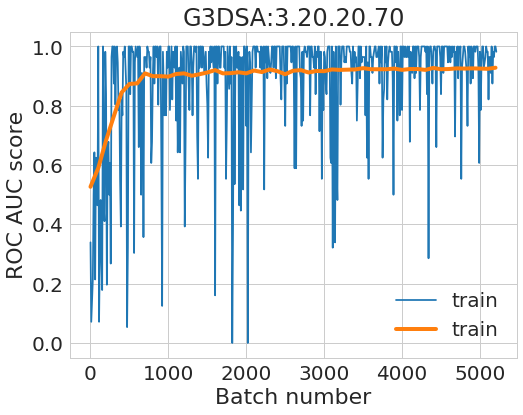

In [147]:
fg, ax = plt.subplots(figsize=(8, 6))

plt.plot(list(zip(*train_performance))[0], list(zip(*train_performance))[1], label='train')
plt.plot(list(zip(*validation_performance))[0], list(zip(*validation_performance))[1], label='train', linewidth=4)
plt.ylim = (0, 1)
plt.legend()
plt.xlabel('Batch number')
plt.ylabel('ROC AUC score')
plt.title('G3DSA:3.20.20.70')

Text(0,0.5,'ROC AUC score')

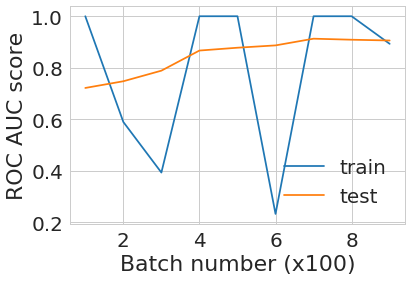

In [115]:
plt.plot(range(1, len(train_performance) + 1), train_performance, label='train')
plt.plot(range(1, len(validation_performance) + 1), validation_performance, label='test')
plt.ylim = (0, 1)
plt.legend()
plt.xlabel('Batch number (x100)')
plt.ylabel('ROC AUC score')

In [49]:
64 * 12

768